# Load functions and modules

In [1]:
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt

import hyperspy.api as hs


from hoglundTools._hyperspy import correlate_1D_in_2D
from hoglundTools._hyperspy.components import Gaussian2D

# Create a signal

  0%|          | 0/129 [00:00<?, ?it/s]

Shifts (units)
[4.160e+01 4.032e+01 3.906e+01 3.782e+01 3.660e+01 3.540e+01 3.422e+01
 3.306e+01 3.192e+01 3.080e+01 2.970e+01 2.862e+01 2.756e+01 2.652e+01
 2.550e+01 2.450e+01 2.352e+01 2.256e+01 2.162e+01 2.070e+01 1.980e+01
 1.892e+01 1.806e+01 1.722e+01 1.640e+01 1.560e+01 1.482e+01 1.406e+01
 1.332e+01 1.260e+01 1.190e+01 1.122e+01 1.056e+01 9.920e+00 9.300e+00
 8.700e+00 8.120e+00 7.560e+00 7.020e+00 6.500e+00 6.000e+00 5.520e+00
 5.060e+00 4.620e+00 4.200e+00 3.800e+00 3.420e+00 3.060e+00 2.720e+00
 2.400e+00 2.100e+00 1.820e+00 1.560e+00 1.320e+00 1.100e+00 9.000e-01
 7.200e-01 5.600e-01 4.200e-01 3.000e-01 2.000e-01 1.200e-01 6.000e-02
 2.000e-02 0.000e+00 0.000e+00 2.000e-02 6.000e-02 1.200e-01 2.000e-01
 3.000e-01 4.200e-01 5.600e-01 7.200e-01 9.000e-01 1.100e+00 1.320e+00
 1.560e+00 1.820e+00 2.100e+00 2.400e+00 2.720e+00 3.060e+00 3.420e+00
 3.800e+00 4.200e+00 4.620e+00 5.060e+00 5.520e+00 6.000e+00 6.500e+00
 7.020e+00 7.560e+00 8.120e+00 8.700e+00 9.300e+00 9.920e+00 1

  0%|          | 0/129 [00:00<?, ?it/s]

[<Axes: xlabel='E axis (meV)', ylabel='q axis (px)'>,
 <Axes: xlabel='E axis (meV)', ylabel='q axis (px)'>]

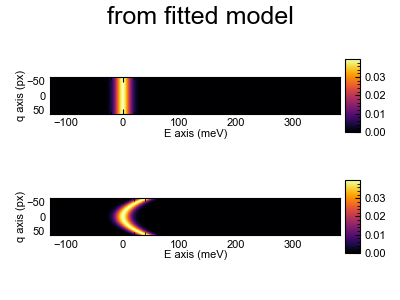

In [15]:
axes = [{'_type': 'UniformDataAxis', 'name': 'q', 'units': 'px',  'navigate': False, 'is_binned': False, 'size': 129, 'scale': 1.0, 'offset': -64.5},
        {'_type': 'UniformDataAxis', 'name': 'E', 'units': 'meV', 'navigate': False, 'is_binned': False, 'size': 1024, 'scale': 0.5, 'offset': -128.}]
s1 = hs.signals.Signal2D(np.zeros((129,1024)), axes=axes)
s2 = hs.signals.Signal2D(np.zeros((129,1024)), axes=axes)

s1 = s1.as_signal1D('E')
s1 = s1.create_model()
g = hs.model.components1D.Gaussian(sigma=10, centre=0.0)
s1.append(g)
s1 = s1.as_signal().as_signal2D(('E','q'))

s2 = s2.as_signal1D('E')
s2 = s2.create_model()
g = hs.model.components1D.Gaussian(sigma=10, centre=0.0)
s2.append(g)

shift = 0.1
shifts_in = ((s2.axes_manager['q'].axis*shift)**2).reshape(g.centre.map['values'].shape).round(2)
shifts_in_px = shifts_in/s1.axes_manager['E'].scale

print(f'Shifts (units)\n{shifts_in}')
# print(f'Shifts  (px)\n{shifts_in_px}')
g.centre.map['values'] = shifts_in
g.centre.map['is_set'] = True

s2 = s2.as_signal().as_signal2D(('E','q'))

fig = plt.figure(figsize=(4,3))
hs.plot.plot_images([s1,s2], per_row=1, fig=fig)
#print(cx/s1.axes_manager['E'].scale)

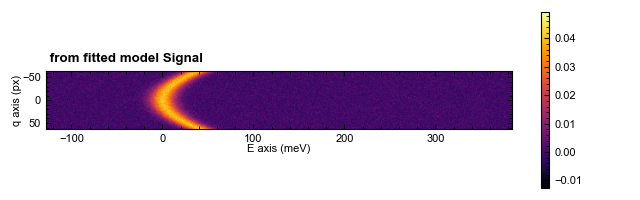

In [16]:
s2.add_gaussian_noise(std=0.003)
s2.plot()

# No triming of data

Find the realtive offset and correlation coefficient. Note the shift is returned in pixels.
The offset can be forward or backward one full spectral axis so is twice the size. The shift in pixels (px) can then be found by finding the lag coresponding to the maximum correlation.

(129,)


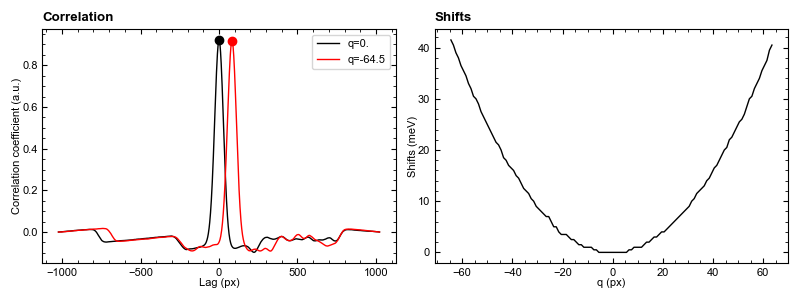

In [17]:
lags, coef = correlate_1D_in_2D(s2.data, s1.data)
px = lags[coef.argmax(1)] #get the shift in pixels
shifts = s2.axes_manager['E'].scale * px #convert to calibrated shifts
print(shifts.shape)

fig,axs = plt.subplots(figsize=(8,3), ncols=2)
axs[0].set_title('Correlation')
axs[0].plot(lags, coef[65], label='q=0.')
axs[0].scatter(px[65], coef[65].max())
axs[0].plot(lags, coef[0], 'r', label='q=-64.5')
axs[0].scatter(px[0], coef[0].max(), c='r')
axs[0].legend()
axs[0].set_xlabel('Lag (px)')
axs[0].set_ylabel('Correlation coefficient (a.u.)')

axs[1].set_title('Shifts')
axs[1].plot(s2.axes_manager['q'].axis, shifts)
axs[1].set_xlabel('q (px)')
axs[1].set_ylabel('Shifts (meV)')

fig.tight_layout()

Apply the shifts

[########################################] | 100% Completed | 114.19 ms


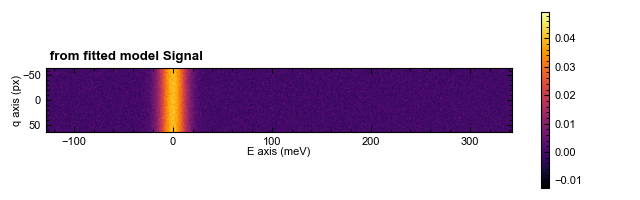

In [18]:
sc = s2.deepcopy().as_signal1D('E')
sc.shift1D(-shifts, crop=True)
sc = sc.as_signal2D(('E','q'))
sc.plot()

# Trim data

(129,)


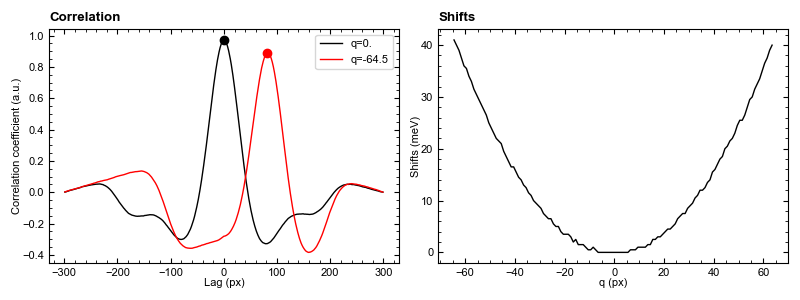

In [19]:
lags, coef = correlate_1D_in_2D(s2.isig[-50.:100.].data, s1.isig[-50.:100.].data)
px = lags[coef.argmax(1)] #get the shift in pixels
shifts = s2.axes_manager['E'].scale * px #convert to calibrated shifts
print(shifts.shape)

fig,axs = plt.subplots(figsize=(8,3), ncols=2)
axs[0].set_title('Correlation')
axs[0].plot(lags, coef[65], label='q=0.')
axs[0].scatter(px[65], coef[65].max())
axs[0].plot(lags, coef[0], 'r', label='q=-64.5')
axs[0].scatter(px[0], coef[0].max(), c='r')
axs[0].legend()
axs[0].set_xlabel('Lag (px)')
axs[0].set_ylabel('Correlation coefficient (a.u.)')

axs[1].set_title('Shifts')
axs[1].plot(s2.axes_manager['q'].axis, shifts)
axs[1].set_xlabel('q (px)')
axs[1].set_ylabel('Shifts (meV)')

fig.tight_layout()

Apply the shifts

[                                        ] | 0% Completed | 1.32 ms

[########################################] | 100% Completed | 109.80 ms


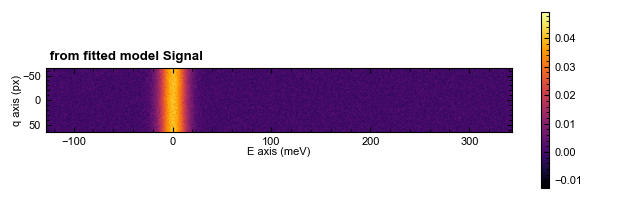

In [20]:
sc = s2.deepcopy().as_signal1D('E')
sc.shift1D(-shifts, crop=True)
sc = sc.as_signal2D(('E','q'))
sc.plot()